# **Introduction:**
We are building binary classification of classifying hotdog and vegroll using fastai.


# Importing Liraries

In [21]:
# !pip install gradio

In [22]:
# !pip install fastai

In [23]:
# !pip install -Uqq fastbook

In [4]:


from fastai.vision.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *



import fastbook
fastbook.setup_book()
from fastbook import *

import shutil
from pathlib import Path
import gradio as gr

# **Data Preparation**

In [5]:

search_terms = ['Vegroll', 'hotdog']
path = Path('food')

# Check if the directory exists
if path.exists():
    shutil.rmtree(path)

# Create directories and download images for each search term
for o in search_terms:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    results = search_images_ddg(f'{o} food', max_images=50)
    download_images(dest, urls=results)


In [6]:
### delete data if the file is not opening

for o in search_terms:
    verify_images(path/o)
    for img in (path/o).ls():
        try:
            # Open image to verify it's not corrupted
            img = PILImage.create(img)
        except Exception as e:
            # If an error occurs during opening, the image file is likely corrupted, so remove it
            img.unlink()


'WindowsPath' object is not iterable
'WindowsPath' object is not iterable


# **Data Preparation**

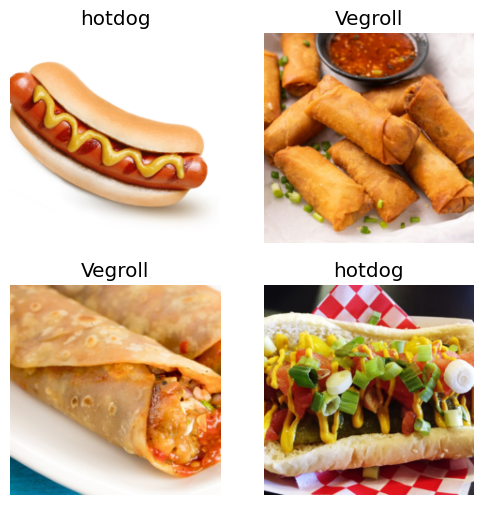

In [7]:
# Define the path to your images
path = Path('food')

# Create a DataBlock
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
)

# Create a DataLoaders object
dls = datablock.dataloaders(path, bs=32)

# Show a batch to verify everything is loaded correctly
dls.show_batch(max_n=4)


# pre-trained model and prepare for training:

C:\Users\JETENDRA\anaconda3\lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\JETENDRA/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 41.1MB/s]


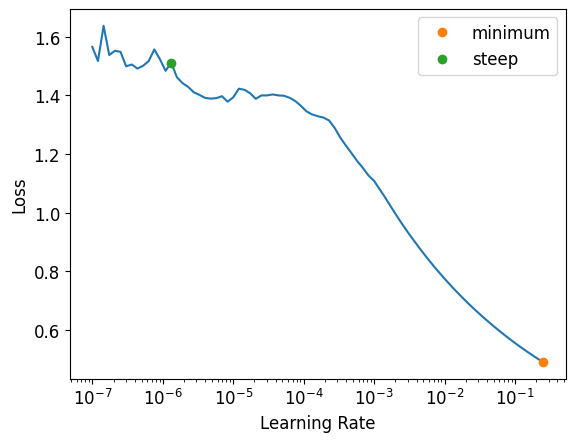

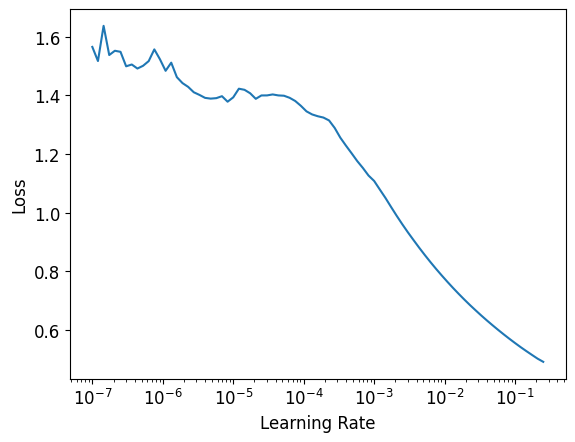

In [8]:
# Create a learner object using a pre-trained model
learn = cnn_learner(dls, resnet18, metrics=error_rate)

# Find an appropriate learning rate
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

# Show the plot for learning rate finder
learn.recorder.plot_lr_find()


The graph depicts the loss declining as the learning rate increases, with the most efficient learning rate marked at the steep drop. After this point, the loss minimizes and eventually rises, indicating the threshold for the learning rate's effectiveness.

# **Training the Model:**

epoch,train_loss,valid_loss,error_rate,time
0,1.377973,1.489487,0.277778,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.295323,0.928575,0.277778,00:13
1,1.212098,0.645280,0.277778,00:13
2,1.143547,0.501929,0.277778,00:13
3,1.291926,0.516064,0.277778,00:14
4,1.357873,0.578249,0.222222,00:14


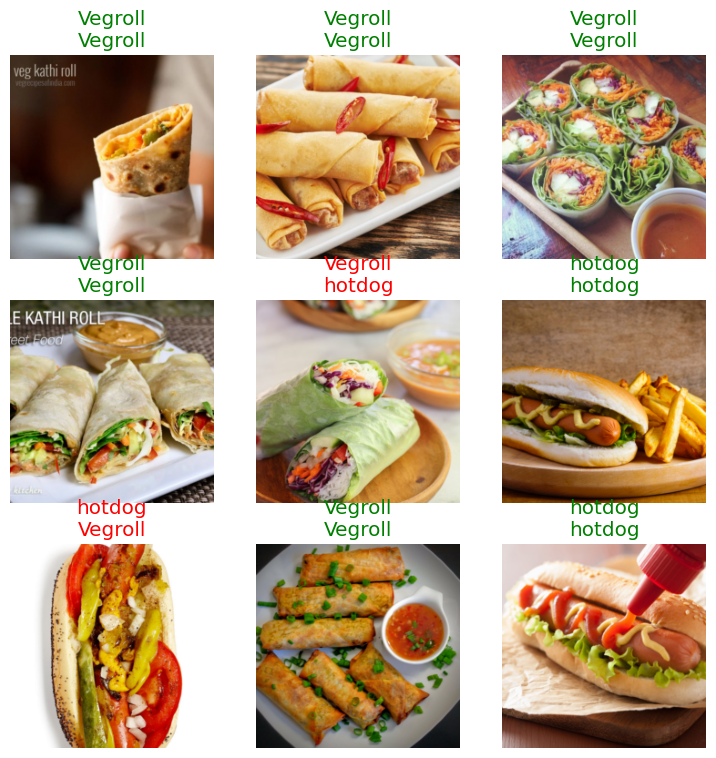

In [9]:
# Pick a learning rate based on the plot
chosen_lr = lr_steep

# Train the model
learn.fine_tune(5, base_lr=chosen_lr)

# After training, you can show the results
learn.show_results()

1. The model’s loss on both training and validation datasets has decreased over time, indicating it's learning effectively.
2. By the last epoch, the model's error rate on the validation set appears consistent, suggesting that the model's predictions are relatively stable.

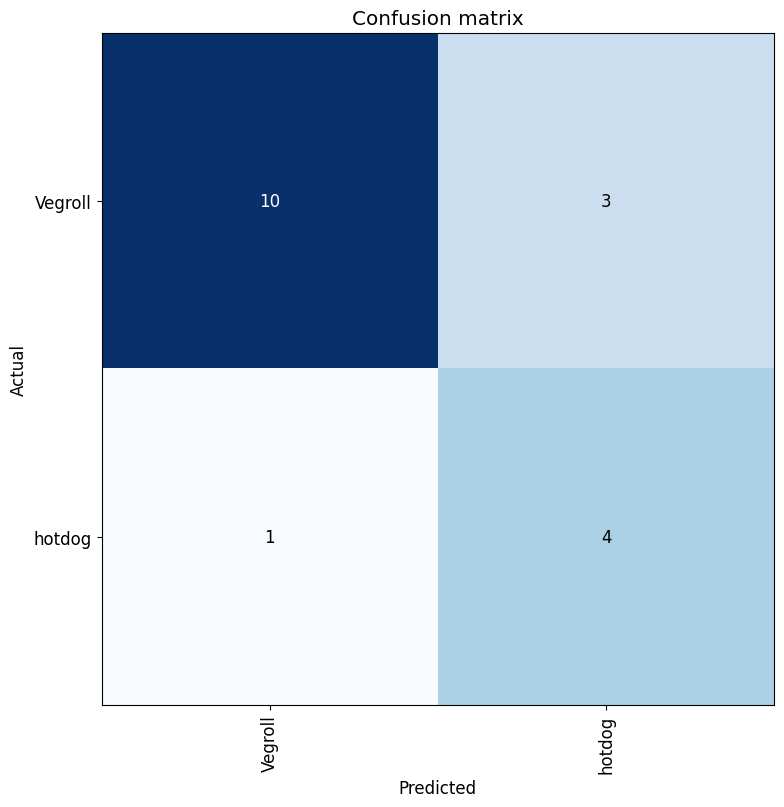

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8, 8))
## interp.plot_top_losses(5)

In [11]:
### Export the model

learn.export()

In [13]:
# Load the exported model
learn_inf = load_learner('export.pkl')

# Test with a new image
learn_inf.predict('Test_Hotdog.png')

('hotdog', tensor(1), tensor([0.3590, 0.6410]))

In [14]:

# Test with a new image
learn_inf.predict('Test_VegRoll.png')

('Vegroll', tensor(0), tensor([0.7362, 0.2638]))

The test images are predicted correctly

# **Deploying the model in gradio**

In [1]:

def predict_image(img):
    img = PILImage.create(img)
    pred, idx, probs = learn_inf.predict(img)
    return pred, probs.max().item()

iface = gr.Interface(fn=predict_image,
                     inputs=gr.Image(type="pil"),
                     outputs=[gr.Label(), gr.Number(label="Probability")])

iface.launch()


NameError: name 'gr' is not defined

In [16]:
## D:\JITHU\Yeshiva - USA\Academics\Spring - 2024\DATA SCIENCE\DAV 6150 - DataScience\Project 3

# **Conclusion:**


1. The model accurately identified and predicted the images of a hotdog and vegroll with good confidence, demonstrating effective learning and generalization from training to practical application.

2. Given the model's consistent error rate and validation loss reduction during training, it appears robust enough to classify new images reliably within the scope of the learned categories.